In [18]:
#@title Instalar bibliotecas necessarias
# !pip install paho-mqtt &> /dev/null
# !pip install gdown &> /dev/null


import uuid
from datetime import datetime

#using randon ID instead of matricula
# ID = str(uuid.uuid4())
ID = 1 # must be filled to indentify collab in mqtt response
topic = "shared_resource/controller/" + str(ID)


def getCurrentTime():
  myobj = datetime.now()
  t = str(myobj.hour)+"_"+str(myobj.minute)+"_"+str(myobj.second)
  return t

session_time = getCurrentTime()

In [17]:
#@title Funções Auxiliares
"""
Recebe uma lista de mensagens e formata a saida
"""
def print_message(msg):
    width = 100

    def format(m: str):
      if m == 'False':
        return "Resposta Errada"
      elif m == 'True':
        return "Resposta Correta"
      else: return m

    msg = map(format, msg)



    print("*" * width)
    print("*" + " " * (width - 2) + "*")
    print("*" + " " * (width - 2) + "*")
    for m in msg:
      print("*" + " " * ((width - len(m)) // 2 - 1) + m + " " * ((width - len(m)) // 2) + "*")
    print("*" + " " * (width - 2) + "*")
    print("*" + " " * (width - 2) + "*")
    print("*" * width)

In [16]:
#@title Classe MQTT que faz o envio dos dados para o controlador e espera uma resposta
import random
import time
from paho.mqtt import client as mqtt_client
import json
import threading

class MQTT:
    """
    Construtor que recebe o topico e o ID da sessao
    """
    def __init__(self, topic, ID, initial_time):
        self._ID = str(ID)
        self.broker = 'broker.hivemq.com'
        self.port = 1883
        # generate client ID with pub prefix randomly
        self.client_id = self._ID+f'{random.randint(0, 1000)}'
        self.client_solution = self._ID+"solution"+f'{random.randint(0, 1000)}'
        self.topic = topic
        self.solution_topic = "colab/response/"+self._ID
        self._message_received = json.dumps(["Empty message! Try monitor a topic to get some response."])
        self.session_time = initial_time
        self.instructions = []

        # print(self.topic)

    def _set_message_received(self, msg):
      self._message_received = msg
    """
    Estabelece uma conexao com o broker
    O ID DEVE SER UNICO
    """
    def _connect_mqtt(self, id):
        def on_connect(client, userdata, flags, rc):
            if rc == 0:
                self._set_message_received(json.dumps(["Conectou no MQTT Broker!"]))
            else:
                self._set_message_received(json.dumps(["Falhou a conexão com o Broker, return code %d\n", rc]))

        client = mqtt_client.Client(id)
        client.on_connect = on_connect
        client.connect(self.broker, self.port)
        return client

    """
    Faz a publicacao de uma mensagem em um topico mqtt, disconecta quando a mesagem e recebida
    """
    def _publish(self,  client, topic, msg):
        time.sleep(1)
        # print(topic, msg)
        result = client.publish(topic, msg)
        status = result[0]
        # print(result)
        if status == 0:
            pass
        else:
            self._set_message_received(json.dumps([f"Failed to send message to topic {topic}"]))
        client.disconnect()  # disconnect gracefully
        client.loop_stop()  # stops network loop


    def _send_instructions(self):
      curr_client = self._connect_mqtt(self.client_id)
      msg = self._mountMessage(self._ID, 0, 0, self.instructions, ["SEND_INSTRUCTIONS"])
      self._publish(curr_client, self.topic, msg)




    """
    Se inscreve num topico mqtt
    """
    def _subscribe(self, client: mqtt_client):
        def on_message(client, userdata, msg):
            self._set_message_received(msg.payload.decode())
            # print(msg.payload.decode())
            # _return = json.loads(msg.payload.decode())
            # if(_return['return'] == "READY"):
            #   self._send_instructions()
            # if(_return['return'] == "END_EXECUTION" or  _return['return'] == "END_TIME_WINDOW"):
            #   print("eueueueueeu")
            client.disconnect()


        client.subscribe(self.solution_topic)
        client.on_message = on_message

    """
    Monta a mensagem passando os parametros no formato esperado e retornando uma string como objeto
    """
    def _mountMessage(self, id, initialTime, responseTime, inst, params):
        # form_question = question.replace('\n', '').replace(',', '')
        msg = {
            "id": id,
            "instructions": inst,
            "generate_time": initialTime,
            "send_time": responseTime,
            "session_start_time": self.session_time,
            "params" : params
        }

        return json.dumps(msg)

    """
    Funcao que realiza a conexao com o nodeRED enviando a resposta e esperando a solucao
    """
    def monitor(self,id, initialTime, responseTime, instructions = []):
        self.instructions = instructions
        msg = self._mountMessage(id, initialTime, responseTime, [], ["GET_QUEUE"])
        # print(msg)
        sub_client = self._connect_mqtt(self.client_solution)

        self._subscribe(sub_client)

        pub_client = self._connect_mqtt(self.client_id)

        self._publish(pub_client, self.topic, msg)

        # callback when timeout is over
        # def _expirationCallback():
        #     self._set_message_received(json.dumps(["Couldn't get response! Please, try Again."]))

        #     sub_client.disconnect()

        # # Define 10s timeout
        # timer = threading.Timer(10.0, _expirationCallback)
        # timer.start()

        sub_client.loop_forever()
        return self._message_received


In [19]:
myMqtt = MQTT(topic, ID, session_time)
instructions = []
arquivo = """trafficlight/green 1 trafficlight/yellow 1 trafficlight/red 1
trafficlight/green 0 trafficlight/yellow 0 trafficlight/red 0
trafficlight/green 1 trafficlight/yellow 1 trafficlight/red 1
trafficlight/green 0 trafficlight/yellow 0 trafficlight/red 0
trafficlight/green 1 trafficlight/yellow 1 trafficlight/red 1
trafficlight/green 0 trafficlight/yellow 0 trafficlight/red 0
trafficlight/green 1 trafficlight/yellow 1 trafficlight/red 1
trafficlight/green 0 trafficlight/yellow 0 trafficlight/red 0"""

for linha in arquivo.split('\n'):
  inst = []
  s = linha.strip().split(" ")

  for i in range(0, len(s), 2):

    instruction = {}
    instruction["topic"] = s[i]
    instruction["operation"] = s[i+1]
    inst.append(instruction)
  instructions.append(inst)


# myMqtt.monitor(ID, 0, 0, instructions)



Average Response Time for 100 requests: 2.9752989268302916 seconds


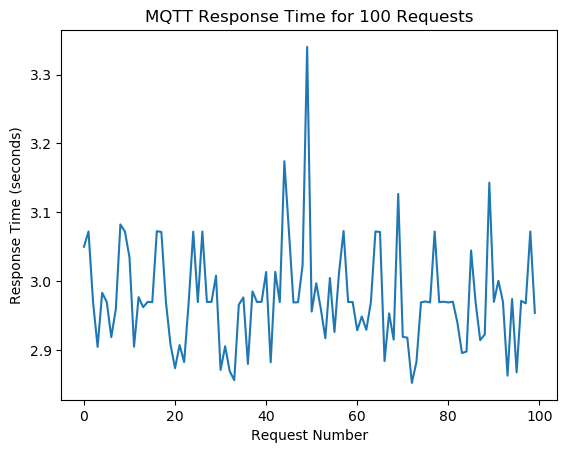

In [20]:
import time
import csv
import matplotlib.pyplot as plt

# ... (your existing code)

class TestBench:
    def __init__(self, mqtt_instance):
        self.mqtt_instance = mqtt_instance

    def run_test(self, num_requests=100, csv_filename='mqtt_test_results.csv'):
        total_response_time = 0
        response_times = []

        with open(csv_filename, mode='w', newline='') as csv_file:
            fieldnames = ['Request', 'Response Time (seconds)']
            writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

            writer.writeheader()

            for i in range(num_requests):
                start_time = time.time()
                response = self.mqtt_instance.monitor(ID, 0, 0, instructions)
                end_time = time.time()

                response_time = end_time - start_time
                total_response_time += response_time
                response_times.append(response_time)

                writer.writerow({'Request': i+1, 'Response Time (seconds)': response_time})

        average_response_time = total_response_time / num_requests
        print(f"\nAverage Response Time for {num_requests} requests: {average_response_time} seconds")

        # Plotting the graph
        self.plot_graph(response_times)

    def plot_graph(self, response_times):
        plt.plot(response_times)
        plt.xlabel('Request Number')
        plt.ylabel('Response Time (seconds)')
        plt.title('MQTT Response Time for 100 Requests')
        plt.show()


# Create an instance of the MQTT class
myMqtt = MQTT(topic, ID, session_time)

# Create an instance of the TestBench class
test_bench = TestBench(myMqtt)  

# Run the test with 100 requests and plot the graph
test_bench.run_test(100)